In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "../data/train"
TEST_DIR = "../data/test"
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names

Found 7364 files belonging to 4 classes.
Using 5892 files for training.
Found 7364 files belonging to 4 classes.
Using 1472 files for validation.
Found 1844 files belonging to 4 classes.


['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [4]:
import json, os
with open(os.path.join(MODEL_DIR, "label_map.json"), "w") as f:
    json.dump({i: name for i, name in enumerate(class_names)}, f)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_prep = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)
train_ds_prep = prepare(train_ds_prep, training=True)
val_ds_prep = prepare(val_ds)
test_ds_prep = prepare(test_ds)

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False 

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
def evaluate_model(model, test_ds_prep, class_names, experiment_name):
    print(f"\n======= Evaluating {experiment_name} =======")

    # Collect predictions
    y_true = []
    y_pred = []
    y_prob = []

    for images, labels in test_ds_prep:
        probs = model.predict(images)
        y_prob.extend(probs)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # METRICS
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"Accuracy:               {accuracy:.4f}")
    print(f"Precision (weighted):   {precision:.4f}")
    print(f"Recall (weighted):      {recall:.4f}")
    print(f"F1 Score (weighted):    {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {experiment_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    y_true_oh = label_binarize(y_true, classes=list(range(len(class_names))))

    plt.figure(figsize=(10, 7))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_oh[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {experiment_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


185/185 ━━━━━━━━━━━━━━━━━━━━ 216s 699ms/step - accuracy: 0.6696 - loss: 0.7991 - val_accuracy: 0.7160 - val_loss: 0.6908
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 115s 622ms/step - accuracy: 0.7636 - loss: 0.5847 - val_accuracy: 0.7391 - val_loss: 0.6107
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 115s 620ms/step - accuracy: 0.7741 - loss: 0.5521 - val_accuracy: 0.6698 - val_loss: 0.7120
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 120s 648ms/step - accuracy: 0.7918 - loss: 0.5092 - val_accuracy: 0.6923 - val_loss: 0.6439
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 118s 639ms/step - accuracy: 0.7919 - loss: 0.5114 - val_accuracy: 0.7079 - val_loss: 0.6359



======= Evaluating Experiment 1 - Frozen MobileNetV2 =======
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━

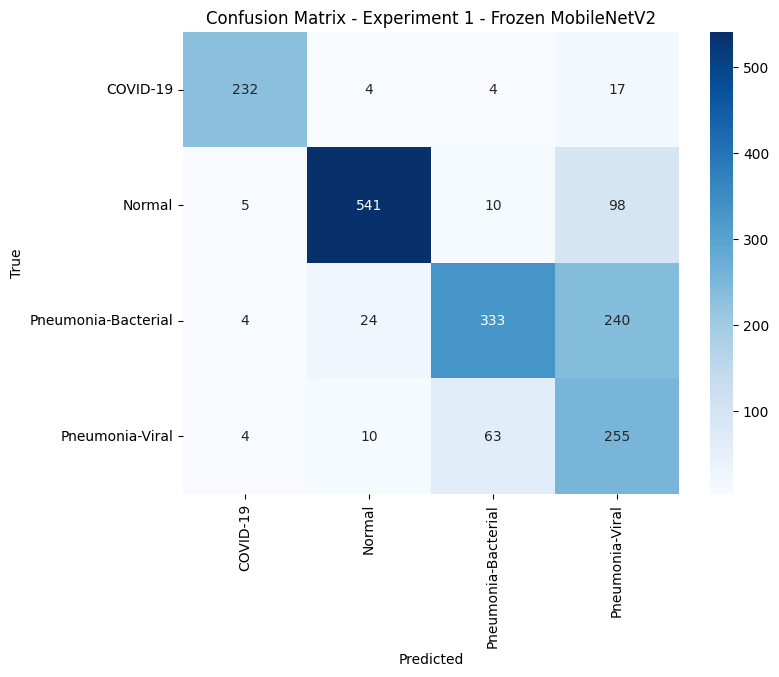

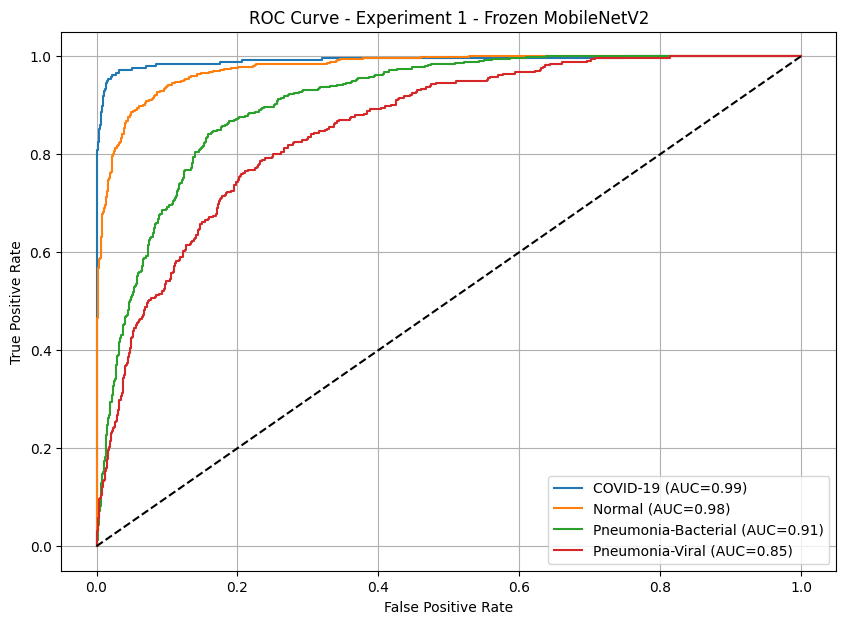

Experiment 1: {'accuracy': np.float64(0.7380694143167028), 'precision': 0.8033390125010634, 'recall': 0.7380694143167028, 'f1': 0.7522286125111529}


In [9]:
metrics_exp1 = evaluate_model(
    model,
    test_ds_prep,
    class_names,
    experiment_name="Experiment 1 - Frozen MobileNetV2"
)

print("Experiment 1:", metrics_exp1)

In [10]:
# Unfreeze top layers of the MobileNetV2 base
base_model.trainable = True

# Freeze the first ~140 layers (tune only the top part)
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

fine_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True)
]

fine_history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10,
    callbacks=fine_callbacks
)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 130s 678ms/step - accuracy: 0.7144 - loss: 0.7375 - val_accuracy: 0.7582 - val_loss: 0.6217
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 124s 670ms/step - accuracy: 0.7850 - loss: 0.5509 - val_accuracy: 0.7812 - val_loss: 0.5666
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 662ms/step - accuracy: 0.7838 - loss: 0.5210 - val_accuracy: 0.7867 - val_loss: 0.5310
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 125s 679ms/step - accuracy: 0.7955 - loss: 0.5111 - val_accuracy: 0.7867 - val_loss: 0.5169
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 661ms/step - accuracy: 0.8031 - loss: 0.4886 - val_accuracy: 0.7874 - val_loss: 0.5099
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 663ms/step - accuracy: 0.8062 - loss: 0.4725 - val_accuracy: 0.7962 - val_loss: 0.4971
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 665ms/step - accuracy: 0.8111 - loss: 0.4614 - val_accuracy: 0.7914 - val_loss: 0.5071
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 124s 671ms/step - accuracy: 0.8174 -


======= Evaluating Experiment 2 - Fine-Tuned MobileNetV2 =======
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1

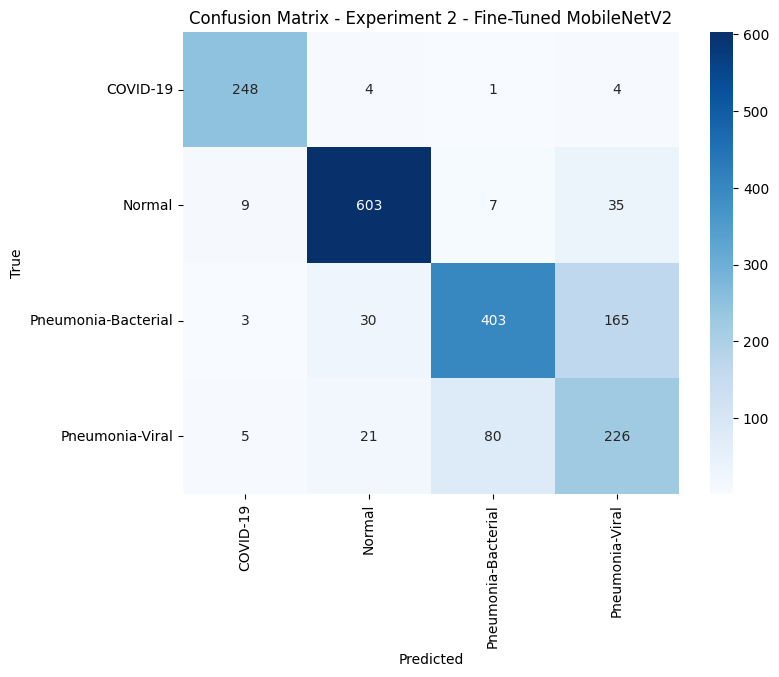

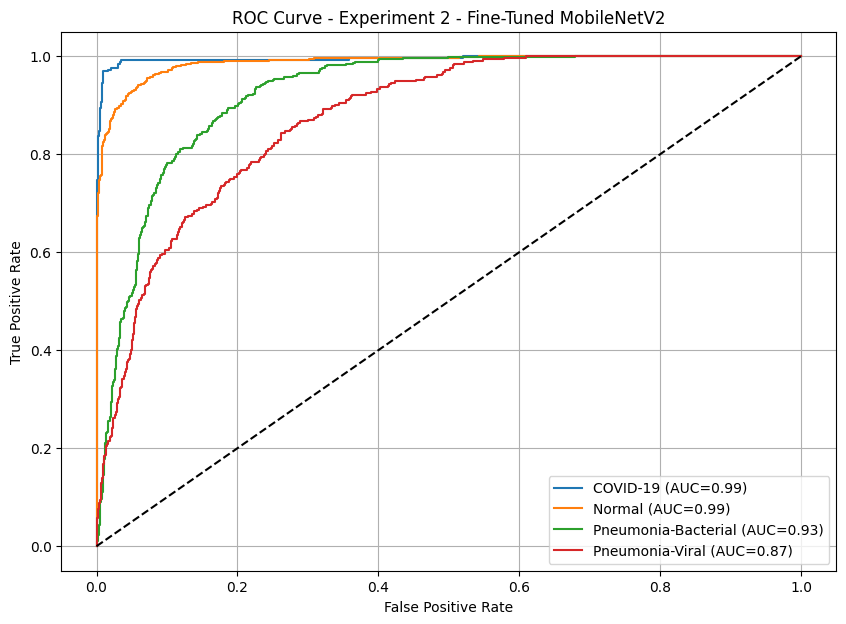

Experiment 2: {'accuracy': np.float64(0.8026030368763557), 'precision': 0.8175844412637936, 'recall': 0.8026030368763557, 'f1': 0.8057974188609905}


In [11]:
metrics_exp2 = evaluate_model(
    model,
    test_ds_prep,
    class_names,
    experiment_name="Experiment 2 - Fine-Tuned MobileNetV2"
)

print("Experiment 2:", metrics_exp2)

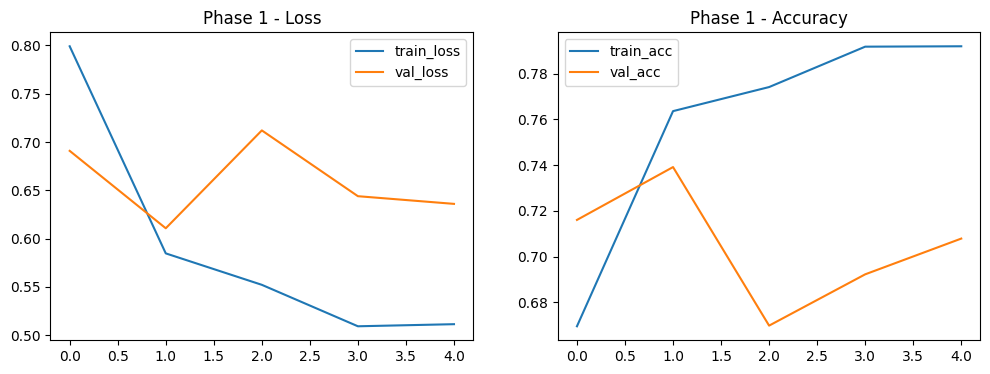

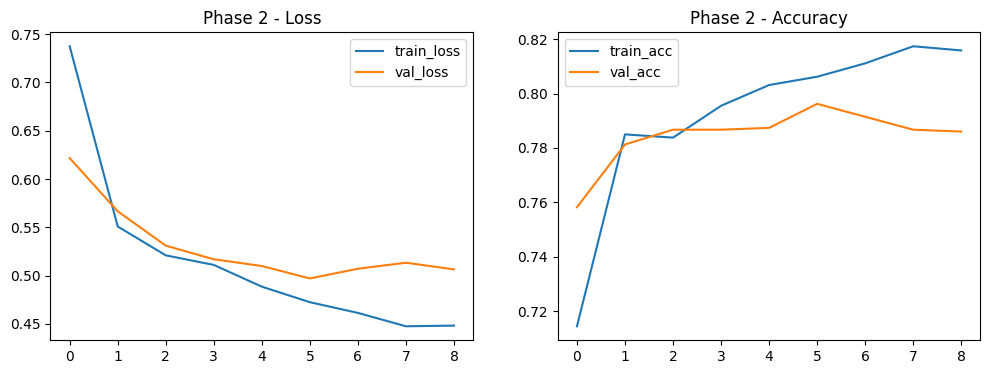

In [15]:
# Plot training history
def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.legend()
    plt.title(f"{title} - Accuracy")
    plt.show()

plot_history(history, "Phase 1")
plot_history(fine_history, "Phase 2")

In [19]:
model.save("../models/mobilenet_pneumonia_finetuned_model.h5")
